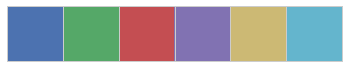

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
pd.options.mode.chained_assignment = None
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
reso=300
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [3]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

In [4]:
df=pd.read_csv("NED28.10.1-D-15.1.0-20181130.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [5]:
def selectdata_lite(mymethod,df):
    dfa=df[~np.isfinite(df.err)|(df.err==0)] # database of non reported errors
    df1=df[np.isfinite(df.err)] # remove measurements that do not report an error
    df1=df1[df1.err!=0] # remove measurements that report an error as zero ¬¬
# Select a method for analysis
    filter=np.full(len(df1), False, dtype=bool)
    for mym in mymethod:
        filter|=(df1.Method==mym) # choose  methods
    df1=df1[filter] 
    namelist=list(df1['Galaxy ID']) # list of galaxies
    counter=collections.Counter(namelist) # count measurements per galaxy
# Select galaxies with a minimum number of measurements
    ulist=[]
    ulist2=[]
    nmeas=1
    for i in counter.keys():
        if counter[i]>nmeas:
            ulist+=[i] # all galaxies with more than n_meas measurements
        if counter[i]>=1:
            ulist2+=[i] # all galaxies with at least one measurement w/a reported error
    print('No. of Galaxies with reported errors is %i' % len(ulist2) )
    print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
# Create database for bootstrap, remove unnecessary columns
    dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # dataframe with galaxies with more than nmeas measurements
    colu=list(df.columns)
    for i in ['Galaxy ID', 'm-M', 'err', 'D (Mpc)']:
        colu.remove(i)
    dfs.drop(colu, inplace=True, axis=1)
# Create database for non-reported errors
    filter=np.full(len(dfa), False, dtype=bool)
    for mym in mymethod:
        filter|=(dfa.Method==mym) # choose  methods
    df1a=dfa[filter] 
    elist=list(np.unique(df1a['Galaxy ID'])) # list of galaxies with measurements without reported errors
    filtr=~np.in1d(elist,ulist2) # select only galaxies with no additional measurements using the same method
    nulista=np.asarray(elist)[filtr] # list of galaxies without reported errors
    print('No. of Galaxies without reported errors is %i' % len(nulista) )
    return ulist,dfs,nulista,df1a,len(nulista),len(ulist),len(ulist2)

In [6]:
mymethod=['Tully-Fisher','Comp. Secondary: Tully-Fisher']
ulist,dfs,nulista,odf,*mma=selectdata_lite(mymethod,df)

No. of Galaxies with reported errors is 11408
No. of Galaxies with more than 1 measurements is 9114
No. of Galaxies without reported errors is 884


In [ ]:
%%time
np.random.seed(10)
nbins=10000 # 1e4 -> 4 minutes
em=[] # number of measurements per galaxy
bootp50=[] # mean error from the bootstrap for each galaxy
bootmsig=[]
bootmother=[]
bootsig=[] # uncertainty of the error -> may not be a good predictor
dboot=[] # mean bootstrap distance
bootmad=[] # median absolute deviation (robust)
wsnt=[] # error propagated from the weighted standard deviation of the distance modulus (natural way to do it)
dwa=[] # distance using weighted average of modulus and err (for show mostly)
ecf=[]
eqd=[]
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    em+=[len(dummy)] # n_meas, number of measurements per galaxy
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))] # bootstrap draw for each gal
    tli=np.array(tli)
    booterr=(np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0))/2 # sigma draws from bootstrap for each gal
    bootmean=np.median(tli,axis=0) # mean draws from bootstrap for each gal
############## This block should be ran for 10k draws ###############
#    mymed=np.median(tli,axis=0) #median for error of m error
#    mst=[np.median(np.abs(tli[:,kk]-mymed[kk])) for kk in range(nbins)]
#    bootmsig+=[(np.percentile(mst, 84,axis=0)-np.percentile(mst, 16,axis=0))/2e6] # error of m error
#    bootmother+=[np.median(mst)/1e6]
#####################################################################
    bootp50+=[np.median(booterr)/1e6] # mean bootstrap error
    bootsig+=[((np.percentile(booterr, 84)-np.percentile(booterr, 16)))/2e6] # the error of the error
    bootmad+=[np.median(np.abs(tli - np.median(tli)))/1e6]
    dboot+=[np.median(bootmean)/1e6] # bootstrap mean D
    wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
    distwav=10**(avnat/5+1)/1e6
    dwa+=[distwav] #
    wsti=0.461*distwav*wnat # weighted standard deviation
    wsnt+=[wsti] 
    ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
    ecf+=[ecfi]
    eqd+=[np.sqrt(ecfi**2+wsti**2)]    
# weighted std using D and propagated err is similar to propagated D error using weighted std on modulus and error

### Do not re-write bootstrap results by executing the next couple of cells. For emergencies only!

In [ ]:
d = {'names': ulist, 'meas': em, 'bootp50':bootp50, 'bootsig':bootsig,'dboot':dboot,'wsnt':wsnt,'dwa':dwa,'ecf':ecf,'eqd':eqd,'bootmad':bootmad}
dfb = pd.DataFrame(data=d)
dfb.to_csv("bootstrap_results_2018.csv")

In [ ]:
d = {'names': ulist, 'meas': em, 'bootmad':bootmad,'bootmsig':bootmsig,'bootmother':bootmother}
dfm = pd.DataFrame(data=d)
dfm.to_csv("bootstrap_results_wm_2018.csv")

### Continue from here

In [14]:
ndf=pd.read_csv("bootstrap_results_2018.csv")
bdf=pd.read_csv("bootstrap_results_wm_2018.csv")
em=ndf.meas
dboot=ndf.dboot
dwa=ndf.dwa
bootp50=ndf.bootp50
wsnt=ndf.wsnt
ecf=ndf.ecf
eqd=ndf.eqd
bootmad=ndf.bootmad
bootsig=ndf.bootsig
bootmsig=bdf.bootmsig
bootmother=bdf.bootmother

In [7]:
filt=(np.array(em)<6)&(np.array(em)>1)
x=np.array(dboot)[filt]
xa=np.array(dwa)[filt]
y=np.array(bootp50)[filt]
w=np.array(wsnt)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]
ms=np.array(bootmsig)[filt]
mo=np.array(bootmother)[filt]

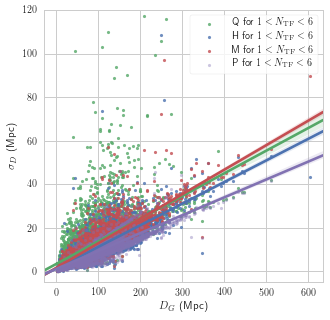

In [8]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $1<N_\mathrm{TF}<6$') # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $1<N_\mathrm{TF}<6$', scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $1<N_\mathrm{TF}<6$', scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $1<N_\mathrm{TF}<6$') # red, cosmicflows
plt.legend(loc='upper right',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(-5,120)
plt.savefig('mnras/hqmlow.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/hqmlow.png', dpi=reso,transparent=True)

In [9]:
filt=np.array(em)>5
x=np.array(dboot)[filt]
xa=np.array(dwa)[filt]
y=np.array(bootp50)[filt]
w=np.array(wsnt)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]
ms=np.array(bootmsig)[filt]
mo=np.array(bootmother)[filt]

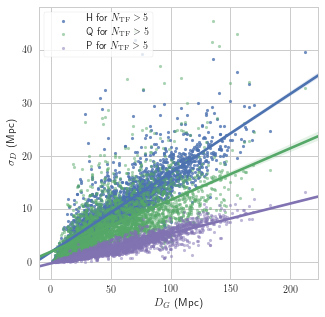

In [10]:
plt.figure(figsize=(5,5))
sns.regplot(x,y,label='H for $N_\mathrm{TF}>5$', scatter_kws={'s':10})
sns.regplot(x,qd, scatter_kws={'alpha':0.5,'s':10},label='Q for $N_\mathrm{TF}>5$') # green, quadrature
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.5,'s':10},label='P for $N_\mathrm{TF}>5$') # purple, cosmicflows
#sns.regplot(x,z, scatter_kws={'alpha':0.3}) # purple, mad
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.savefig('mnras/hqp.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/hqp.png', dpi=reso,transparent=True)

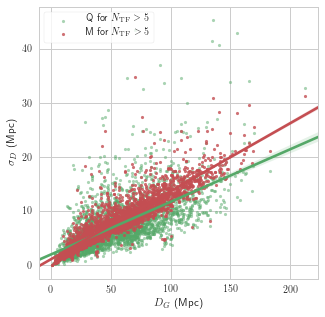

In [11]:
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1],label='Q for $N_\mathrm{TF}>5$', scatter_kws={'alpha':0.5,'s':10}) 
sns.regplot(x,z,color=current_palette[2],label='M for $N_\mathrm{TF}>5$', scatter_kws={'alpha':0.8,'s':10}) # red, MAD
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.savefig('mnras/qm.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/qm.png', dpi=reso,transparent=True)

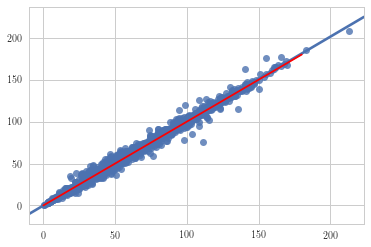

In [12]:
sns.regplot(x,xa)
plt.plot([0,180],[0,180],c='r')

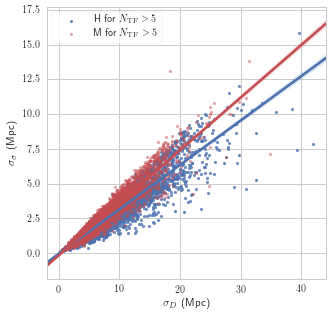

In [13]:
plt.figure(figsize=(5,5))
sns.regplot(y,ee,color=current_palette[0], scatter_kws={'s':10},label='H  for $N_\mathrm{TF}>5$') # error of the error
sns.regplot(z,ms,color=current_palette[2], scatter_kws={'alpha':0.5,'s':10},label='M for $N_\mathrm{TF}>5$') # error of the error

plt.xlabel(r"$\sigma_D$ (Mpc)")
plt.ylabel(r'$\sigma_\sigma$ (Mpc)')
plt.legend(frameon=True)
plt.savefig('mnras/ee.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/ee.png', dpi=reso,transparent=True)

(array([ 111.,  473.,  492.,  454.,  338.,  369.,  345.,  247.,  178.,
         132.,   99.,   67.,   40.,   25.,    8.,   10.,    0.,    1.,
           0.,    1.]),
 array([   0.76107182,   11.35552103,   21.94997025,   32.54441946,
          43.13886868,   53.73331789,   64.32776711,   74.92221632,
          85.51666553,   96.11111475,  106.70556396,  117.30001318,
         127.89446239,  138.48891161,  149.08336082,  159.67781004,
         170.27225925,  180.86670846,  191.46115768,  202.05560689,
         212.65005611]),
 <a list of 20 Patch objects>)

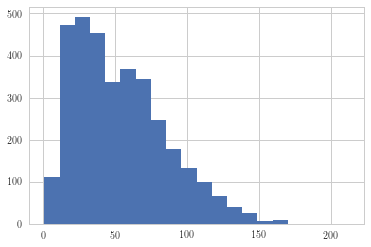

In [14]:
plt.hist(x,bins=20)

# Working Models

## Linear Model

Works for n_meas > 14 (468 galaxies), but discrepancy plot shows different distributions for simulated and observed discrepancies. $\sigma_B$ is the bootstrap-obtained (real) error, $\sigma_{SW}$ is the sigma used for statistical weight in likelihood.

$$\sigma_B=mD+b $$
$$\sigma_{SW}=f\sigma_B$$

We don't like it because it is not super-physical. Also, it's better not to use $\sigma_\sigma$, as we do not have it for empty measurements. We should also look at empty measurements for galaxies that have other measurements.

In [15]:
def lnlike2(theta, x, y):
    m ,b, f = theta
    model = m * x + b    
    inv_sigma2 = 1.0/((f*model)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior2(theta):
    m, b, f = theta
    if 0 < m < 5 and 0 < b < 2 and 0 < f < 1:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob2(theta, x, y):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y)

def discrep2(ii,samples,x,y):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x+samples[i,1]
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x+modpar[1],(modpar[0]*x+modpar[1])*modpar[2])
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.scatter(disco,discs,alpha=0.4,label=r"$N_\mathrm{TF}>$ "+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax+10,2)
        plt.plot(ppp,ppp,c='r')
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))


732
13 0.184698651653 1.03353541124 0.244102950346
13 [ 0.18465065  1.0350872   0.24490615]
Rejection rate = 1 %
Bayesian p-value: 0.951395324889
600
14 0.186433870185 1.03995045024 0.252203378067
14 [ 0.18635444  1.04195382  0.25313384]
Rejection rate = 2 %
Bayesian p-value: 0.875090777052
477
15 0.19940135683 0.774766680967 0.258611600212
15 [ 0.19924568  0.77947494  0.25992805]
Rejection rate = 3 %
Bayesian p-value: 0.590244411949


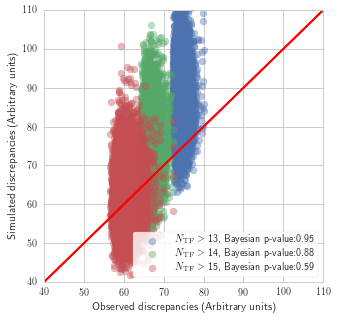

In [16]:
plt.figure(figsize=(5,5))
nh=13
for i in range(nh,nh+3):
    filt=np.array(em)>i
    print(filt.sum())
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    nll = lambda *args: -lnlike2(*args)## AQUI
    result = op.minimize(nll, [1.]*3, args=(x, y)) ## AQUI
    m_ml, b_ml,f_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml)## AQUI
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y)) ## AQUI
    # 2. Let the walkers walk 10000 steps (1000 will do the trick as well)
    steps=10000
    sampler.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    sth=samples.mean(axis=0)
    print(i,sth)
    discrep2(i,samples,x,y)
plt.legend(loc='lower right',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(40,110)
plt.ylim(40,110)
plt.savefig('mnras/discl.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/discl.png', dpi=reso,transparent=True)
# store for prediction below
sth1=sth
samples1=samples
x1=x
y1=y
nhmax=nh+2

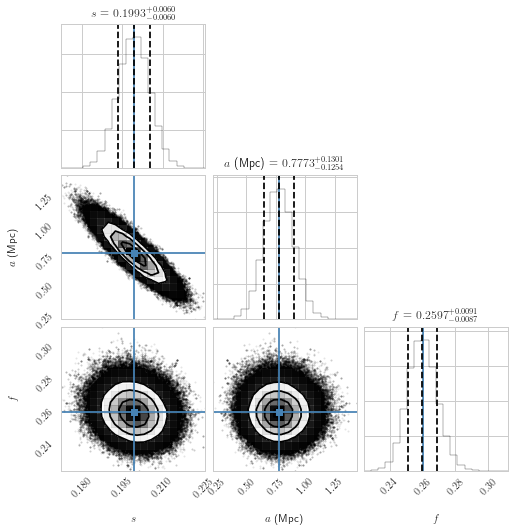

In [17]:
fig = corner.corner(samples, labels=["$s$", "$a$ (Mpc)","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerl.pdf', dpi=reso,transparent=True)

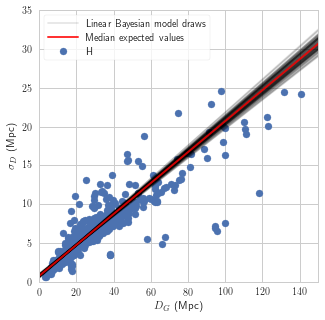

In [18]:
plt.figure(figsize=(5,5))
xl = np.linspace(0,160,2)
sth=np.median(samples,axis=0)
plt.figure(figsize=(5,5))
for m, b,f in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="k", alpha=0.1,label="Linear Bayesian model draws")
plt.scatter(x,y,label='H')
plt.plot(xl, sth[0]*xl+sth[1], color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,35)
plt.savefig('mnras/drawsl.pdf', dpi=reso,transparent=True)

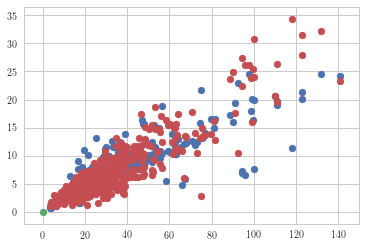

In [19]:
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x+modpar[1],modpar[2]*(modpar[0]*x+modpar[1]))
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)

37.3473611733 8.58044430361
37.8507675844 9.40073494176
39.7338805136 9.92432273683


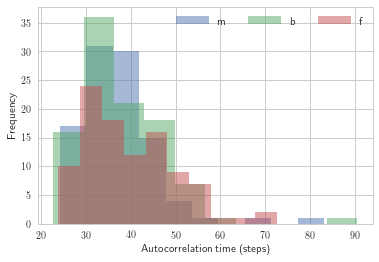

In [20]:
for j in range(3):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['m','b','f'],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

1180
11 0.138951215996 0.601548300923 0.219277552129
11 [ 0.13893045  0.60237386  0.21974336]
Rejection rate = 0 %
Bayesian p-value: 0.996453541392
926
12 0.141318289813 0.540071476554 0.228716029361
12 [ 0.14127453  0.54147057  0.22922448]
Rejection rate = 0 %
Bayesian p-value: 0.942891982522
732
13 0.141415263308 0.522741632541 0.2311582309
13 [ 0.14136692  0.52435018  0.23184632]
Rejection rate = 0 %
Bayesian p-value: 0.605182926829


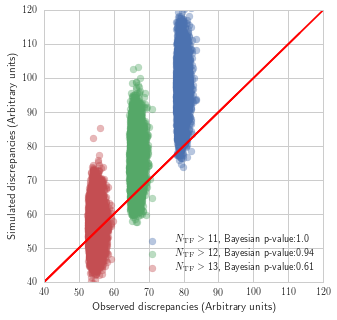

In [21]:
plt.figure(figsize=(5,5))
nm=11
for i in range(nm,nm+3):
    filt=np.array(em)>i
    print(filt.sum())
    x=np.array(dboot)[filt]
    y=np.array(bootmad)[filt]
    nll = lambda *args: -lnlike2(*args)## AQUI
    result = op.minimize(nll, [1.]*3, args=(x, y)) ## AQUI
    m_ml, b_ml,f_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml)## AQUI
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y)) ## AQUI
    # 2. Let the walkers walk 10000 steps (1000 will do the trick as well)
    steps=10000
    sampler.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    sth=samples.mean(axis=0)
    print(i,sth)
    discrep2(i,samples,x,y)
plt.legend(loc='lower right')
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(40,120)
plt.ylim(40,120)
plt.savefig('mnras/discl2.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/discl2.png', dpi=reso,transparent=True)
# store for prediction below
sth2=sth
samples2=samples
x2=x
y2=y
nmmax=nm+2

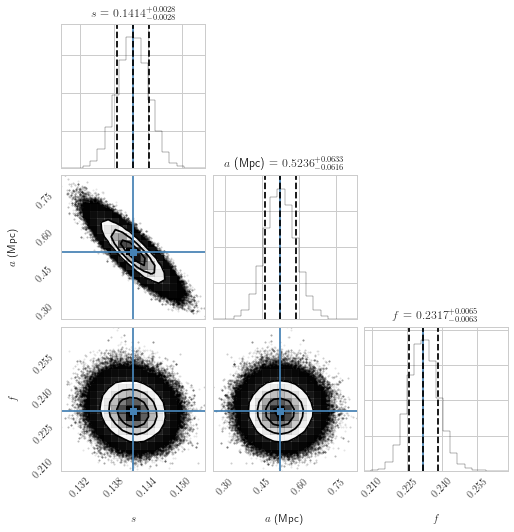

In [22]:
fig = corner.corner(samples, labels=["$s$", "$a$ (Mpc)","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerl2.pdf', dpi=reso,transparent=True)

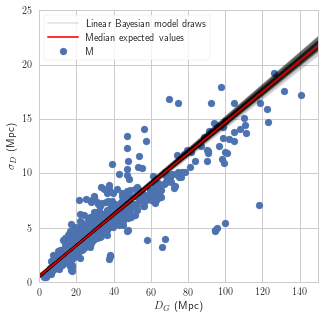

In [23]:
plt.figure(figsize=(5,5))
xl = np.linspace(0,160,2)
sth=np.median(samples,axis=0)

for m, b,f in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="k", alpha=0.1,label="Linear Bayesian model draws")
plt.scatter(x,y,label='M')
plt.plot(xl, sth[0]*xl+sth[1], color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,25)
plt.savefig('mnras/drawsl2.pdf', dpi=reso,transparent=True)

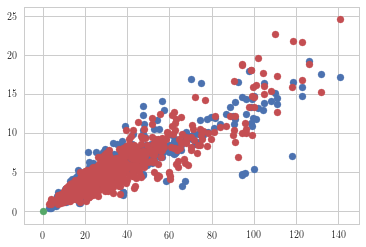

In [24]:
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x+modpar[1],modpar[2]*(modpar[0]*x+modpar[1]))
plt.scatter(x,y)
plt.scatter([0],[0])
plt.scatter(x,ysim)

39.6803850232 12.0243912433
39.0783288304 11.1731067052
39.6999135525 10.8873585115


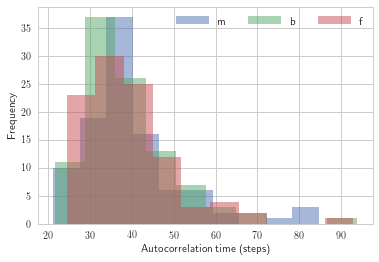

In [25]:
for j in range(3):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['m','b','f'],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

## Quadrature

$$\sigma_D=\sqrt{(mD+c)^2+b^2 }$$
$$\sigma_{SW}=f\sigma_D$$
Quadrature model with multiplicative and additive terms in systematic error. It shows numerical instability due to the degeneracy between the zero offset error and the random error.


If an additive term is added to the systematic error, we go back to the linear model, as $b$ goes to zero in the MCMC.

In [26]:
def lnlike4(theta, x, y):
    m ,b,f,c = theta
    model = np.sqrt((m*x+c)**2+ b**2)
    inv_sigma2 = 1.0/(f*model)**2
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior4(theta):
    m, b, f,c = theta
    if 0 < m < 1 and -10 < b < 10 and 0 < f < 1 and 0 < c < 10:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob4(theta, x, y):
    lp = lnprior4(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike4(theta, x, y)

def discrep4(ii,samples,x,y):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=(samples[i,0]*x+samples[i,3])**2+samples[i,1]**2
        yexp=np.sqrt(yexp)
        modpar=samples[np.random.randint(len(samples))]
        ymod=(modpar[0]*x+modpar[3])**2+modpar[1]**2
        ymod=np.sqrt(ymod)
        ysim=np.random.normal(ymod,modpar[2]*ymod)
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.scatter(disco,discs,alpha=0.4,label=r"$N_\mathrm{TF}>$ "+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax+10,2)
        plt.plot(ppp,ppp,c='r')

        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

70
23 0.227713516149 -4.68545964467e-07 0.251506926141 0.511225209013
23 [ 0.22349454  0.00127923  0.2606899   0.49840883]
Rejection rate = 0 %
Bayesian p-value: 0.0559629290152
49
24 0.251203412704 -7.06105515693e-07 0.258006661852 0.189906604394
24 [ 0.23149593  0.00199538  0.27200254  0.43374079]
Rejection rate = 1 %
Bayesian p-value: 0.132428973637
31
25 0.25683730689 -1.9407000791e-05 0.255887323893 0.197770850693
25 [ 0.22454833 -0.00162642  0.27845609  0.59541032]
Rejection rate = 1 %
Bayesian p-value: 0.683792237092


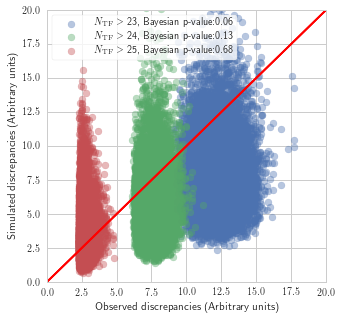

In [27]:
plt.figure(figsize=(5,5))
for i in range(23,26):
    filt=np.array(em)>i
    print(filt.sum())
    xx=np.array(dboot)[filt]
    yy=np.array(bootp50)[filt]
    nll = lambda *args: -lnlike4(*args)## AQUI
    result = op.minimize(nll, [1.]*4, args=(xx, yy)) ## AQUI
    m_ml, b_ml,f_ml,c_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml,c_ml)## AQUI
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    samplerq = emcee.EnsembleSampler(nwalkers, ndim, lnprob4, args=(xx, yy)) ## AQUI
    # 2. Let the walkers walk 10000 steps (1000 will do the trick as well)
    steps=20000
    samplerq.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samplesq = samplerq.chain[:, 200:, :].reshape((-1, ndim)) 
    sthq=samplesq.mean(axis=0)
    print(i,sthq)
    discrep4(i,samplesq,xx,yy)
plt.legend(loc='upper left',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(0,20)
plt.ylim(0,20)
plt.savefig('mnras/discq.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/discq.png', dpi=reso,transparent=True)

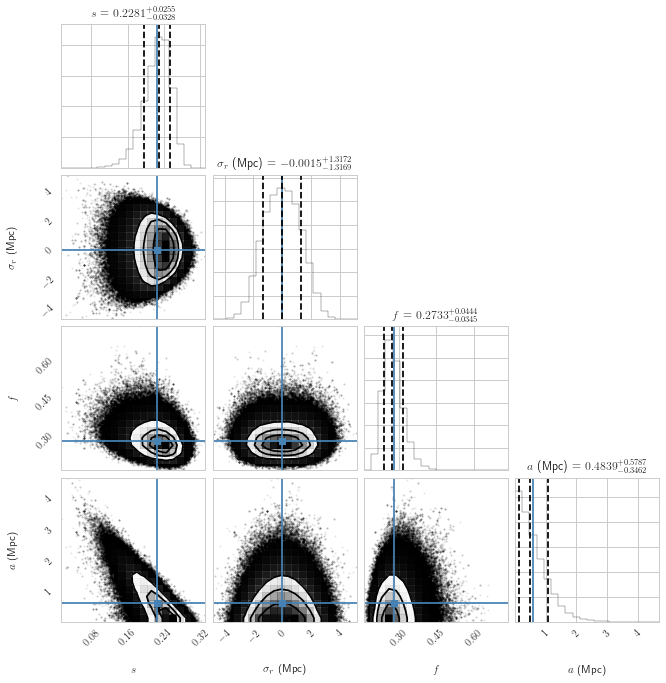

In [28]:
fig = corner.corner(samplesq, labels=["$s$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerq.pdf', dpi=reso,transparent=True)

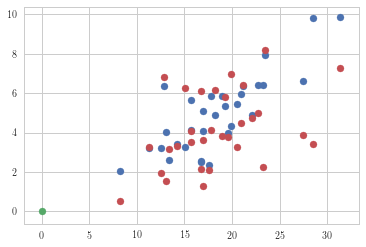

In [29]:
modparq=samplesq[np.random.randint(len(samplesq))]
ymod=np.sqrt((modparq[0]*xx+modparq[3])**2+modparq[1]**2)
ysim=np.random.normal(ymod,modparq[2]*ymod)
plt.scatter(xx,yy)
plt.scatter([0],[0])
plt.scatter(xx,ysim)

63.6265219042 10.3799241478
85.0054246219 16.4549182133
60.7908860763 9.19886382286
67.9241423553 11.7291032541


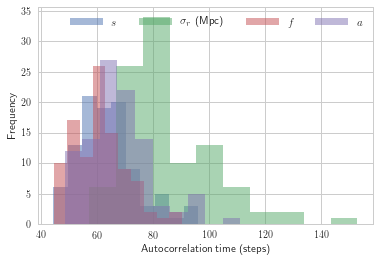

In [30]:
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(samplerq.chain[i,:,j],c=3))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ["$s$", r"$\sigma_r$ (Mpc)","$f$","$a$"],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

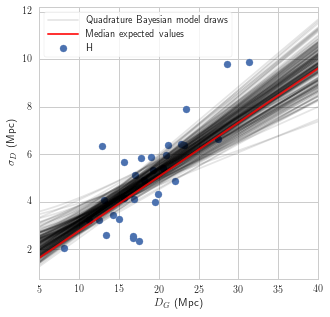

In [31]:
plt.figure(figsize=(5,5))
plt.scatter(xx,yy,label="H")
xl = np.linspace(5,40,2000)
sthq=np.median(samplesq,axis=0)

for m, b,f,c in samplesq[np.random.randint(len(samplesq), size=200)]:
    plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1)
plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1,label="Quadrature Bayesian model draws")
plt.plot(xl, np.sqrt((sthq[0]*xl+sthq[3])**2+sthq[1]**2), color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(5,40)
plt.savefig('mnras/drawsq.pdf', dpi=reso,transparent=True)

926
12 0.141318290255 -8.24334629998e-08 0.228716029375 0.540071468545
12 [  1.41316923e-01  -1.74408828e-04   2.29474948e-01   5.35507841e-01]
Rejection rate = 0 %
Bayesian p-value: 0.943505700326
732
13 0.141415244057 6.82734616837e-08 0.23115823649 0.522741858086
13 [  1.41458903e-01  -2.18291374e-04   2.32126172e-01   5.15260084e-01]
Rejection rate = 0 %
Bayesian p-value: 0.613534447615


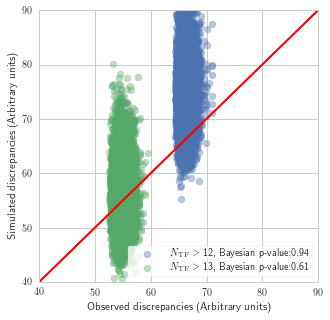

In [32]:
plt.figure(figsize=(5,5))
for i in range(12,14):
    filt=np.array(em)>i
    print(filt.sum())
    xx=np.array(dboot)[filt]
    yy=np.array(bootmad)[filt]
    nll = lambda *args: -lnlike4(*args)## AQUI
    result = op.minimize(nll, [1.]*4, args=(xx, yy)) ## AQUI
    m_ml, b_ml,f_ml,c_ml = result["x"]## AQUI
    print(i,m_ml,b_ml,f_ml,c_ml)## AQUI
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    samplerq = emcee.EnsembleSampler(nwalkers, ndim, lnprob4, args=(xx, yy)) ## AQUI
    # 2. Let the walkers walk 10000 steps (1000 will do the trick as well)
    steps=10000
    samplerq.run_mcmc(pos, steps);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samplesq = samplerq.chain[:, 120:, :].reshape((-1, ndim)) 
    sthq=samplesq.mean(axis=0)
    print(i,sthq)
    discrep4(i,samplesq,xx,yy)
plt.legend(loc='lower right',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(40,90)
plt.ylim(40,90)
plt.savefig('mnras/discq2.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/discq2.png', dpi=reso,transparent=True)

50.0579241353 14.3747179917
47.3636574317 11.8934693231
51.5791911847 16.4954684852
47.6670156611 12.004392646


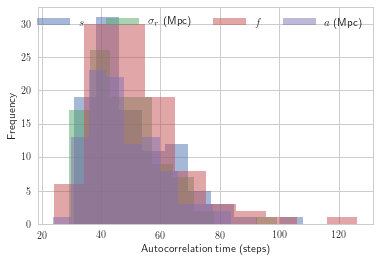

In [33]:
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(samplerq.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ["$s$", r"$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

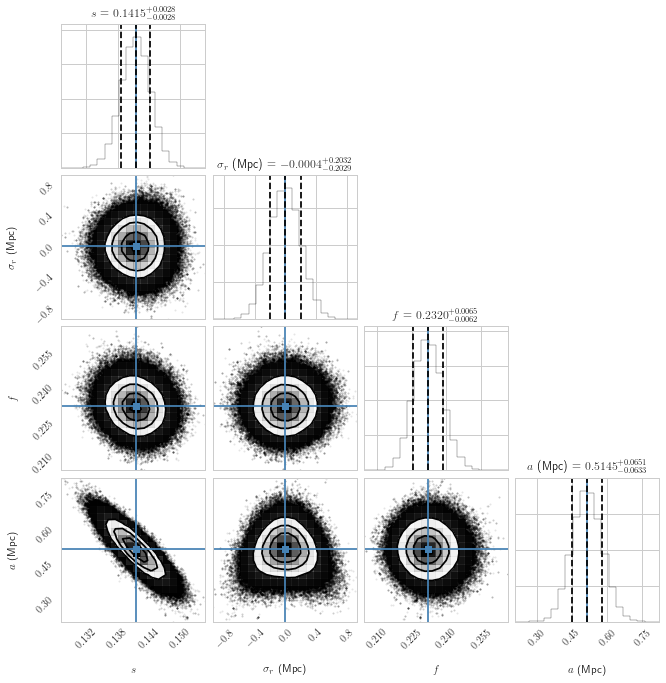

In [34]:
fig = corner.corner(samplesq, labels=["$s$", "$\sigma_r$ (Mpc)","$f$","$a$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
plt.savefig('mnras/cornerq2.pdf', dpi=reso,transparent=True)

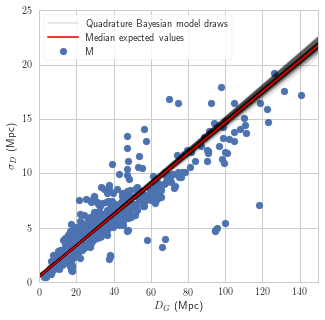

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(xx,yy,label="M")
sthq=np.median(samplesq,axis=0)
xl = np.linspace(0,150,200)
for m, b,f,c in samplesq[np.random.randint(len(samplesq), size=100)]:
    plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1)
plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1,label="Quadrature Bayesian model draws")
plt.plot(xl, np.sqrt((sthq[0]*xl+sthq[3])**2+sthq[1]**2), color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,25)
plt.savefig('mnras/drawsq2.pdf', dpi=reso,transparent=True)

In [60]:
np.savetxt('posterior_lh.txt',samples1)
np.savetxt('posterior_lm.txt',samples2)

## Prediction for non reported errors

In [19]:
samples1=np.loadtxt('posterior_lh.txt')
samples2=np.loadtxt('posterior_lm.txt')

(array([ 1252.,   477.,  1359.,    61.,    44.,    31.,     2.,     9.,
            2.,     2.]),
 array([  1. ,   2.2,   3.4,   4.6,   5.8,   7. ,   8.2,   9.4,  10.6,
         11.8,  13. ]),
 <a list of 10 Patch objects>)

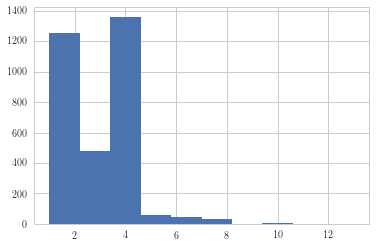

In [7]:
# odf is the data frame where galaxis without any reported TF errors are
counter=collections.Counter(odf['Galaxy ID'])
norep=np.array(list(counter.values()))
plt.hist(norep)

In [8]:
# fraction with 1 meas, 95th percentile meas, max meas
100*(norep==1).sum()//len(norep),np.percentile(norep,95),norep.max()

(31, 4.0, 13)

In [9]:
meddist=[]
for i in nulista:
    dummy=odf[odf['Galaxy ID']==i]
    meddist+=[np.median(dummy['D (Mpc)'])]
meddist=np.array(meddist)

(array([ 359.,  205.,  126.,   84.,   42.,   31.,   25.,    9.,    0.,    3.]),
 array([  7.66000000e-02,   2.70689400e+01,   5.40612800e+01,
          8.10536200e+01,   1.08045960e+02,   1.35038300e+02,
          1.62030640e+02,   1.89022980e+02,   2.16015320e+02,
          2.43007660e+02,   2.70000000e+02]),
 <a list of 10 Patch objects>)

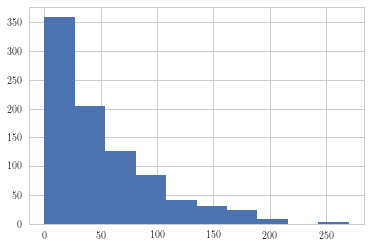

In [10]:
plt.hist(meddist)

In [15]:
filt=np.array(em)>nhmax
x1=np.array(dboot)[filt]
y1=np.array(bootp50)[filt]
filt1=(meddist<x1.max())&(meddist>x1.min())
(filt1).sum() # galaxies in range for H model

810

In [16]:
filt=np.array(em)>nmmax
x2=np.array(dboot)[filt]
y2=np.array(bootmad)[filt]
filt2=(meddist<x2.max())&(meddist>x2.min())
(filt2).sum() # galaxies in range for M model

815

In [17]:
filt=np.array(em)>5
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
z=np.array(bootmad)[filt]

In [20]:
sth1=np.median(samples1,axis=0)
sth2=np.median(samples2,axis=0)

In [21]:
x1.min(),x1.max() #this goes into filter for HyperLEDA

(3.9122037449839042, 140.95405772213078)

In [22]:
x2.min(),x2.max() #this goes into filter for HyperLEDA

(2.8319525532201122, 140.95405772213078)

In [32]:
lims=np.array([x1.min(),x1.max(),x2.min(),x2.max()])
np.savetxt('lims.txt',lims)

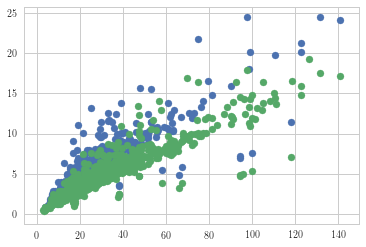

In [23]:
plt.scatter(x1,y1) # H errors
plt.scatter(x2,y2) # M errors

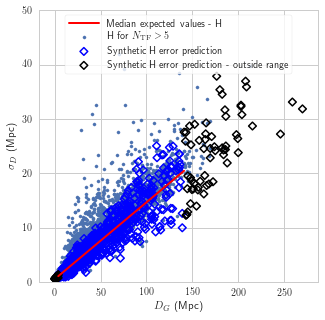

In [27]:
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,y,s=10,label='H for $N_\mathrm{TF}>5$')
xp=np.linspace(x1.min(),x1.max(),2)
modpar=samples1[np.random.randint(len(samples1))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
#plt.scatter(x1,y1,label='H for $N>15$ measurements')
mark='D'
plt.scatter(meddist[filt1],ysim[filt1],linewidth='1.5', facecolors='none', edgecolors='b',s=30,marker=mark,label='Synthetic H error prediction')
plt.scatter(meddist[~filt1],ysim[~filt1], linewidth='1.5', facecolors='none', edgecolors='k',s=30,marker=mark,label='Synthetic H error prediction - outside range')
plt.plot(xp,xp*sth1[0]+sth1[1],c='r',linewidth=2,label='Median expected values - H')
plt.ylim(0,50)
plt.legend(frameon=True,loc='upper center')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')
plt.savefig('mnras/predl1.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/predl1.png', dpi=reso,transparent=True)

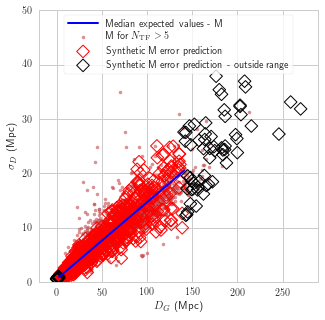

In [29]:
np.random.seed(10)
plt.figure(figsize=(5,5))
plt.scatter(x,z,c=current_palette[2],s=10,label='M for $N_\mathrm{TF}>5$',alpha=0.6)
xp=np.linspace(x2.min(),x2.max(),2)
modpar=samples2[np.random.randint(len(samples2))]
ymod=modpar[0]*meddist+modpar[1]
ysim=np.random.normal(ymod,modpar[2]*ymod)
#plt.scatter(x2,y2,c=current_palette[1],label='M for $N>13$ measurements')
mark='D'
plt.scatter(meddist[filt2],ysim[filt2], linewidth='1', facecolors='none', edgecolors='r',s=80,marker=mark,label='Synthetic M error prediction')
plt.scatter(meddist[~filt2],ysim[~filt2], linewidth='1', facecolors='none', edgecolors='k',s=80,marker=mark,label='Synthetic M error prediction - outside range')
plt.plot(xp,xp*sth2[0]+sth2[1],c='b',linewidth=2,label='Median expected values - M')
plt.ylim(0,50)
plt.legend(frameon=True,loc='upper center')
plt.xlabel('$D_G$ (Mpc)')
plt.ylabel('$\sigma_D$ (Mpc)')
plt.savefig('mnras/predl2.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/predl2.png', dpi=reso,transparent=True)

(array([ 359.,  205.,  126.,   84.,   42.,   31.,   25.,    9.,    0.,    3.]),
 array([  7.66000000e-02,   2.70689400e+01,   5.40612800e+01,
          8.10536200e+01,   1.08045960e+02,   1.35038300e+02,
          1.62030640e+02,   1.89022980e+02,   2.16015320e+02,
          2.43007660e+02,   2.70000000e+02]),
 <a list of 10 Patch objects>)

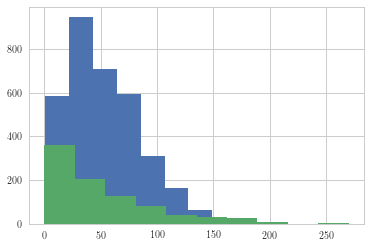

In [57]:
plt.hist(x)
plt.hist(meddist)

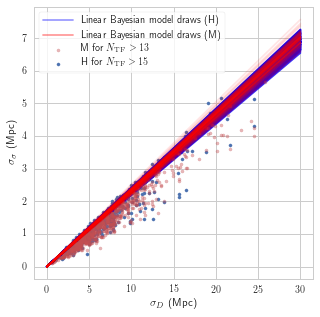

In [63]:
plt.figure(figsize=(5,5))
di=np.linspace(0,30,2)
for m, b,f in samples1[np.random.randint(len(samples1), size=100)]:
    plt.plot(di, f*di, zorder=1, color="b", alpha=0.8)
plt.plot(di, f*di,color="b", alpha=0.4,label="Linear Bayesian model draws (H)")
for m, b,f in samples2[np.random.randint(len(samples2), size=100)]:
    plt.plot(di, f*di, color="r", alpha=0.1)
plt.plot(di, f*di, color="r", alpha=0.4,label="Linear Bayesian model draws (M)")
filt=np.array(em)>13
y=np.array(bootp50)[filt]
ms=np.array(bootmsig)[filt]
plt.scatter(y,ms,s=10,c=current_palette[2],alpha=0.4,label='M for $N_\mathrm{TF}>13$',zorder=2)
filt=np.array(em)>15
y=np.array(bootp50)[filt]
ee=np.array(bootsig)[filt]
plt.scatter(y,ee,s=10,c=current_palette[0],alpha=1,label='H for $N_\mathrm{TF}>15$',zorder=1)
plt.legend(frameon=True)
plt.xlabel(r"$\sigma_D$ (Mpc)")
plt.ylabel(r'$\sigma_\sigma$ (Mpc)')
plt.savefig('mnras/drawsee.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/drawsee.png', dpi=reso,transparent=True)

In [64]:
ndf.meas[ndf.meas>nmmax].sum() # total measurements in M linear model / M quadratic model

13054

In [65]:
ndf.meas[ndf.meas>nhmax].sum() # total measurements in H linear model

9361

In [64]:
ndf.meas[ndf.meas>25].sum() # total measurements in H quadratic model

812

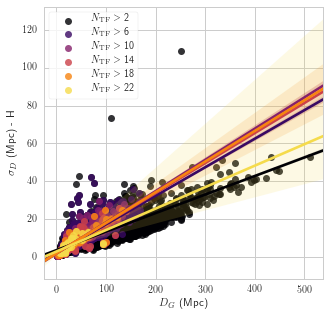

In [69]:
from matplotlib.pyplot import cm
color=cm.inferno(np.linspace(0,1,12))
plt.figure(figsize=(5,5))
for i in range(2,24,4):
    filt=(np.array(ndf.meas[ndf.meas>1])>i)
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    sns.regplot(x,y,color=color[(i-2)//2],label='$N_\mathrm{TF}>$ '+str(i))
                #current_palette[(i-2)//2]) # green, quadrature 
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc) - H')
plt.savefig('mnras/HrelerrTF.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/HrelerrTF.png', dpi=reso,transparent=True)

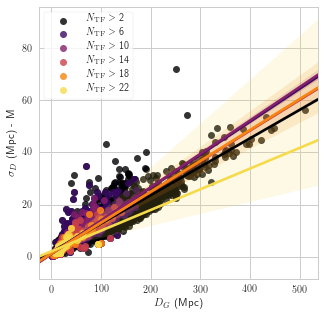

In [70]:
from matplotlib.pyplot import cm
color=cm.inferno(np.linspace(0,1,12))
plt.figure(figsize=(5,5))
for i in range(2,24,4):
    filt=(np.array(ndf.meas[ndf.meas>1])>i)
    x=np.array(dboot)[filt]
    y=np.array(bootmad)[filt]
    sns.regplot(x,y,color=color[(i-2)//2],label='$N_\mathrm{TF}>$ '+str(i))
                #current_palette[(i-2)//2]) # green, quadrature 
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc) - M')
plt.savefig('mnras/MrelerrTF.pdf', dpi=reso,transparent=True)
plt.savefig('mnras/MrelerrTF.png', dpi=reso,transparent=True)